<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Sentiment_analysis_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis using Neural Networks

The aim of this work is to perform a sentiment analysis of the movie reviews database containing 50000 reviews from IMDB. I need to build some models able to distinguish between positive and negative reviews.  To do this I must use different techniques from the NLP domain and go with the neural networks approach instead of the classical ML approach fulfilled in the previous work.

Importing needed libraries:

In [ ]:
import pandas as pd
import numpy as np
import nltk
import scipy
import string
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, r2_score

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import copy
from pathlib import Path
from timeit import default_timer as timer
# Import tqdm for progress bar
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

Downloading NLTK components (stopwords etc):

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Setup device agnostic code:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Auxiliary functions:

In [ ]:
def remove_punct(text):
  # Remove all punctuation signs from the given text
  return "".join([char if char not in string.punctuation else ' ' for char in text])

In [ ]:
def get_corpus_statistics(col, top_num, verbose=0):
  # Calculating the total number of words in the corpus and frequency of use for every word
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    corpus += text
    corpus += ' '
  words = remove_punct(corpus).lower().split()
  word_counts = Counter(words)

  result = {}
  if verbose!=0:
    print('Size of vocabulary: ',len(list(word_counts)))
    print(f'Most {top_num} common words are:')
  for item in word_counts.most_common(top_num):
    result[item[0]] = int(item[1])
  return result

In [ ]:
def model_save(model, name):
  # Saves models parameters

  # Create model save path
  MODEL_NAME = name
  MODEL_SAVE_PATH = FILE_PATH +'/'+ MODEL_NAME

  # Save the model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [ ]:
def load_model(model_cls, name):
  # Loads model's parameters

  loaded_model_1 = model_cls

  MODEL_SAVE_PATH = FILE_PATH +'/'+ name

  # Load model state dict
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

  # Put model to target device
  loaded_model_1.to(device)

  print(f"Loaded model:\n{loaded_model_1}")
  print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
  return loaded_model_1

In [ ]:
def plot_train_progress(train_loss, test_loss, train_acc, test_acc, epochs, metric_type="acc"):
    # Plots learning curves for the loss, and the metric (default - accuracy)

    epoch_count = [i for i in range(1,epochs+1)]
    #train_loss = [x.item() for x in train_losses]
    #test_loss = [x.item() for x in test_losses]


    if metric_type == "acc":
      m_name = 'Accuracy'
    elif metric_type == "r2":
      m_name = 'R2 Score'

    plt.subplots(1, 2, figsize=(24, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, train_loss, label="Train loss")
    plt.plot(epoch_count, test_loss, label="Test loss")
    plt.grid(linestyle=':', color='k')
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, train_acc, label="Train " + m_name )
    plt.plot(epoch_count, test_acc, label="Test " + m_name)
    plt.grid(linestyle=':', color='k')
    plt.title("Training and test " + m_name + " curves")
    plt.ylabel(m_name)
    plt.xlabel("Epochs")
    plt.legend();
    plt.show()

In [ ]:
def report(y_data, predictions):
  # Prints classification report plus F2-score
  predictions = pd.DataFrame(predictions).copy()

  plt.rcParams['figure.figsize'] = (4, 4)
  cm = confusion_matrix(y_data, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  plt.rcParams['figure.figsize'] = (10,8)
  print(classification_report(y_data, predictions))
  print(f'F2-Score: {fbeta_score(y_data, predictions, beta=2.0):.2f}')

In [ ]:
def accuracy(predictions, target):
  # Calculates accuracy
  corrects = (predictions == target)
  accuracy = corrects.sum().float() / float(target.size(0))
  return accuracy

In [ ]:
SEED = 844

Mounting Google Drive and loading the dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/"

Mounted at /content/drive


In [ ]:
filename = 'LargeMovieReviewDataset.csv'
df = pd.read_csv(os.path.join(FILE_PATH, filename))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Detailed EDA of this dataset was performed during the fulfillment of the previous task on a sentiment classification. Here is the link: https://colab.research.google.com/drive/1EZSP3q3BJ-2rPsnb6VHKTFwEhia5KmNm?usp=sharing

# Cleaning & Preprocessing the data

First, I need to clear all texts from unwanted elements such as digits, html tags, URLs, special symbols, etc. So I prepared a set of short functions for these purposes. Later they all will be combined in one preprocessing pipeline:

Removing extra whitespaces

In [ ]:
def remove_whitespace(text):
    return  " ".join(text.split())

Removing HTML tags

In [ ]:
def remove_tag(text):

    text=''.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r' ', text)

Removing numbers

In [ ]:
def remove_numbers(text):

    text=''.join(text)
    number_pattern = re.compile('\d+')
    return number_pattern.sub(r' ', text)

Removing URLs

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
    return url_pattern.sub(r'', text)

Removing special symbols

In [ ]:
def remove_spec_symbols(text):
  text=''.join(text)
  #nonascii_pattern = re.compile('[^\x00-\x7F]+')
  unicode_pattern = re.compile('[^\u0000-\u007F]+')
  return unicode_pattern.sub(r' ', text)

Removing stopwords

As our main task is to define the sentiment of the review I assume that the words "not" and "no" might be significant in the case of analyzing n-grams with lengths of 2 and more (N-grams like "not good", "not bad" etc. might have value in the classification task). That's why I decided to exclude these words from the stop-words list before filtering.

In [ ]:
stop_words = set(stopwords.words('english'))
deselect_stop_words = ['no', 'not']
sw = list(stop_words)
for w in sw:
  if w in deselect_stop_words:
    sw.remove(w)
sw = set(sw)

In [ ]:
def remove_stopwords(text):
    result = ""
    text = text.split()
    for word in text:
      if word not in sw:
        result += word
        result += ' '
    return result

Lemmatization

In [ ]:
def lemmatization(text):

    result = ""
    text = text.split()
    wordnet = WordNetLemmatizer()
    for word, tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
          pos='n'
        result += wordnet.lemmatize(word,pos)
        result += ' '
    return result

Stemming

In [ ]:
def stemming(text):
    porter = PorterStemmer()

    result = ""
    text = text.split()
    for word in text:
      result += porter.stem(word)
      result += ' '
    return result

Obviously, if we count words usage frequencies on the raw corpus we will get just auxiliary words in the top list. They do not have their own meaning and couldn't give any value to our models, so we must remove them during preprocessing.

In [ ]:
get_corpus_statistics(df['review'][:100], 10)

{'the': 1381,
 'a': 679,
 'and': 651,
 'of': 624,
 'to': 531,
 'br': 458,
 'is': 419,
 'in': 385,
 'it': 364,
 'i': 304}

The function that performs all preprocessing tasks on a given corpus:

In [ ]:
def preprocessing(d_frame, column, baseform_method='none'):
  df = d_frame.copy()
  df[column] = df[column].str.lower()
  df[column] = df[column].apply(remove_tag)
  df[column] = df[column].apply(remove_numbers)
  df[column] = df[column].apply(remove_urls)
  df[column]=df[column].apply(remove_stopwords)
  df[column]=df[column].apply(remove_punct)
  df[column]=df[column].apply(remove_spec_symbols)
  df[column]=df[column].apply(remove_whitespace)
  if baseform_method == 'stemm':
    df[column]=df[column].apply(stemming)
  elif baseform_method == 'lemm':
    df[column]=df[column].apply(lemmatization)

  return df

Preprocessing of the corpus:

In [ ]:
df = preprocessing(df, 'review')
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there s family little boy jake think...,negative
4,petter mattei s love time money visually stunn...,positive


Now the top list seems much better:

In [ ]:
get_corpus_statistics(df[df['sentiment']=='negative']['review'], 20, 1)

Size of vocabulary:  71221
Most 20 common words are:


{'movie': 50118,
 's': 43896,
 'film': 37597,
 'not': 32447,
 'one': 26283,
 'like': 22458,
 'no': 16063,
 'even': 15254,
 'i': 14854,
 'good': 14728,
 'bad': 14726,
 'would': 14007,
 'it': 13715,
 'time': 12357,
 'really': 12355,
 'see': 10753,
 'story': 10186,
 'get': 10136,
 'much': 10118,
 'people': 9468}

Finally, I'll remove one-letter words that also have a high frequency (probably remains of "I'm", "he's" kind of words)

In [ ]:
sw.update(['s', 'm', 'b', 'd', 'll','re'])
df['review']=df['review'].apply(remove_stopwords)

### Building vocab in Torchtext style

Let's build the vocabulary for our models. First I am putting all the texts into one list:

In [ ]:
texts = list(df.review)
texts[:5]

['one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy not high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due l

I'll use tokenizer from torchtext library to split texts into words (tokens):

In [ ]:
tokenizer = get_tokenizer('basic_english')

Defining the iterator:

In [ ]:
def yield_tokens(examples):
  # Yield tokens for each element in the corpus
  for example in examples:
    tokens = tokenizer(example)
    yield tokens

token_generator = yield_tokens(df['review'])

Creating a dictionary - assigning integer values for 50000 most frequent words in the corpus (in descending order). It's also adding two special words to denote unknown words and padding.

In [ ]:
vocab = build_vocab_from_iterator(token_generator, specials=['<unk>', '<pad>'], max_tokens=50000)

In [ ]:
vocab.set_default_index(vocab['<unk>'])

In [ ]:
print(f'Unique words in vocab: {len(vocab)}')

Unique words in vocab: 50000


Defining a function to translate text into tensor of integers according to the vocabulary:

In [ ]:
def text_to_tensor(text: str, vocab_dict: dict, unk_token='<unk>', verbose=False):
    '''
    Arguments:
        text - string containing the text
        vocab_dict - term vocabulary
        unk_token - special char used to map the unknown items
        verbose - print debug messages
    Returns:
        tensor_l - a tensor containing the indices of our terms
    '''
    if verbose:
        print("List of words in our text:")
        print(text)

    # initialize empty tensor
    tensor_l = []

    # take the __UNK__ value fro mthe vocabulary
    if unk_token in vocab_dict:
      unk_ID = vocab_dict[unk_token]
    else: unk_ID = 99999

    if verbose:
        print(f"UNK has a value of {unk_ID}")

    text = text.split()
    # for each word in the lsit:
    for word in text:
        # take the index
        # if the word is not in vocab_dict, then assign UNK
        if word in vocab_dict:
          word_ID = vocab_dict[word]
        else:
          word_ID = unk_ID
        # append to tensor list
        tensor_l.append(word_ID)

    return tensor_l

Encoding the corpus of reviews in to list of Integer by using above dictionary:

In [ ]:
def encode_corpus(texts, vocab):
  encoded_texts=list()
  for text in texts:
    encoded_text = text_to_tensor(text, vocab)
    encoded_texts.append(encoded_text)
  return encoded_texts

In [ ]:
encoded_reviews = encode_corpus(texts, vocab)

Making all the encoded_review of the same length (padding shorter texts with <pad> words at the beginning of the text):

In [ ]:
def corpus_padding(texts, sequence_length):
  if isinstance(texts[0], list):
    features=np.ones((len(texts), sequence_length), dtype=int)
    for i, review in enumerate(texts):
      review_len=len(review)
      if (review_len<=sequence_length):
        pad=list(np.ones(sequence_length-review_len))
        new=pad+review
      else:
        new=review[:sequence_length]
      features[i,:]=np.array(new)
  else:

    review_len=len(texts)
    if (review_len<=sequence_length):
      pad=list(np.ones(sequence_length-review_len))
      features=pad+texts
    else:
      new=review[:sequence_length]
      features=np.array(new)
  return features

I decided to limit the text to 400 words as this is far above the 75% quantile value for the number of words in reviews which is 291 (according to statistics that I derived in a previous classification task).  So following this, I assume 85-90% of all texts will fall within this limitation. All remaining reviews will be shortened but I suppose 400 words will be enough for models to detect their sentiments.

In [ ]:
features = corpus_padding(encoded_reviews, 400)

In [ ]:
features[0]

array([    1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,

In [ ]:
cnt = 0
for f in features:
  if f[0] != 1:
    cnt+=1
print(cnt)

1098


As we can see here there are only 1098 reviews that were shortened. It's less than 5% of all corpus.

Finally, before training models, it is necessary  to convert labels into integers:

In [ ]:
df['sentiment'] = df['sentiment'].replace('positive',1)
df['sentiment'] = df['sentiment'].replace('negative',0)

## Baseline (Linear model)

In the first stage, I am going to build a linear aka feed-forward neural network, and use it as a baseline for further models. Data will be encoded using Tf IDF before being fed to the model:

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=20)
texts_transformed = vectorizer.fit_transform(texts)

In [ ]:
texts_transformed.shape

(50000, 17526)

In [ ]:
X, y = texts_transformed, df['sentiment'].values

Trying to convert the sparse matrix obtained after TfIdf vectorizing into the torch tensor I faced the continuously repeating crashing of the Colab runtime due to available RAM exceeding. To avoid it I created a custom Pytorch dataset which will keep the data in its initial format (sparse) and will sequentially convert record-wise while using it as an iterator in DataLoader:

In [ ]:
class TfidfDataset(Dataset):
    """Tfidf vectorized dataset."""

    def __init__(self, tfidf, labels):
        self.tfidf = tfidf
        self.labels = labels


    def __len__(self):
        return self.tfidf.shape[0]

    def __getitem__(self, i):
      return (torch.tensor(self.tfidf[i].todense()), torch.tensor(self.labels[i], dtype=torch.long))

Splitting dataset into three parts - train, validation, and test:

In [ ]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=.4, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=.5, shuffle=True)

Instantiating three custom TfidfDataset-s in accordance with three sets we have:

In [ ]:
train_ds = TfidfDataset(X_train, y_train)
val_ds = TfidfDataset(X_val, y_val)
test_ds = TfidfDataset(X_test, y_test)

In [ ]:
train_ds[0][0].shape

torch.Size([1, 12481])

Defining DataLoaders:

In [ ]:
#dataloader
batch_size=5000
train_loader=DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_ds, batch_size=batch_size, shuffle=True)

Defining a simple NN model consisting of two linear layers:

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Linear, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, text):
        text = text.float() # dense layer deals with float datatype
        x = self.fc1(text)
        x = self.fc2(x)
        return x

Instantiating the model:

In [ ]:
input_length = 17526
hidden_size = 2048
num_classes = 1
linear_model = Linear(input_length, hidden_size, num_classes).to(device)
print(linear_model)

Linear(
  (fc1): Linear(in_features=17526, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
from torchsummary import summary
summary(linear_model, input_size=(17526,),device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]      35,895,296
            Linear-2                    [-1, 1]           2,049
Total params: 35,897,345
Trainable params: 35,897,345
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/backward pass size (MB): 0.02
Params size (MB): 136.94
Estimated Total Size (MB): 137.02
----------------------------------------------------------------


Defining learning rate, the loss function and the optimizer:

In [ ]:
lr=0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=lr)

Train loop:

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    for inputs, labels in iterator:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        y_logits = model(inputs).squeeze()
        predictions = torch.round(torch.sigmoid(y_logits))

        loss = criterion(y_logits.squeeze(), labels.squeeze().float())
        acc = accuracy(predictions.squeeze(), labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Test loop:

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels  in iterator:
            inputs = inputs.to(device)
            labels = labels.to(device)

            y_logits = model(inputs).squeeze()
            predictions = torch.round(torch.sigmoid(y_logits))

            loss = criterion(y_logits.squeeze(), labels.float())
            acc = accuracy(predictions.squeeze(), labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The function performing all model's training process:

In [ ]:
def run_train(epochs, model, train_iterator, valid_iterator, optimizer, criterion, model_type):
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in range(epochs):

        # train the model
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # evaluate the model
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        val_losses.append(valid_loss)
        val_accs.append(valid_acc)

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights'+'_'+model_type+'.pt')


        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f} | Test loss: {valid_loss:.5f}, Test acc: {valid_acc:.2f}")

    return train_losses, val_losses, train_accs, val_accs

Training:

In [ ]:
model_type = 'Linear'
num_epochs = 15
tr_loss, tst_loss, tr_acc, tst_acc = run_train(num_epochs, linear_model, train_loader,  val_loader, optimizer, criterion, model_type)

Epoch: 0 | Loss: 0.65370, Accuracy: 0.75 | Test loss: 0.59017, Test acc: 0.84
Epoch: 1 | Loss: 0.52350, Accuracy: 0.86 | Test loss: 0.46838, Test acc: 0.85
Epoch: 2 | Loss: 0.39621, Accuracy: 0.88 | Test loss: 0.37434, Test acc: 0.86
Epoch: 3 | Loss: 0.30181, Accuracy: 0.90 | Test loss: 0.31766, Test acc: 0.87
Epoch: 4 | Loss: 0.23789, Accuracy: 0.92 | Test loss: 0.28729, Test acc: 0.88
Epoch: 5 | Loss: 0.19406, Accuracy: 0.93 | Test loss: 0.27460, Test acc: 0.89
Epoch: 6 | Loss: 0.16294, Accuracy: 0.95 | Test loss: 0.27215, Test acc: 0.89
Epoch: 7 | Loss: 0.13895, Accuracy: 0.96 | Test loss: 0.27471, Test acc: 0.89
Epoch: 8 | Loss: 0.11916, Accuracy: 0.96 | Test loss: 0.28008, Test acc: 0.88
Epoch: 9 | Loss: 0.10303, Accuracy: 0.97 | Test loss: 0.28792, Test acc: 0.88
Epoch: 10 | Loss: 0.08950, Accuracy: 0.98 | Test loss: 0.29758, Test acc: 0.88
Epoch: 11 | Loss: 0.07816, Accuracy: 0.98 | Test loss: 0.30805, Test acc: 0.88
Epoch: 12 | Loss: 0.06840, Accuracy: 0.99 | Test loss: 0.31835

Learning curves for the linear model:

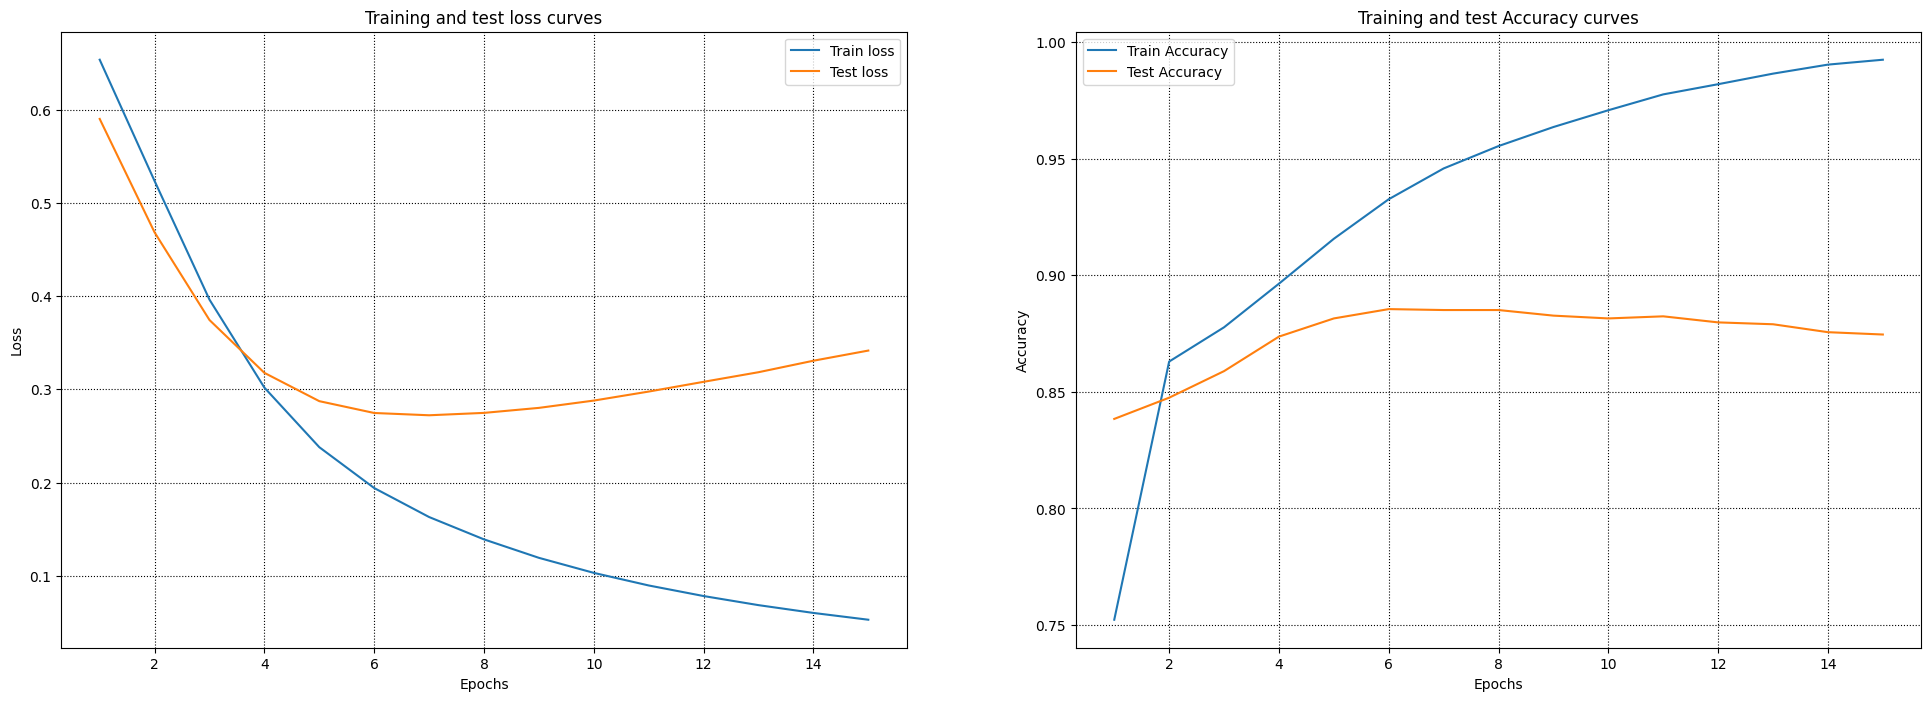

In [ ]:
plot_train_progress(tr_loss, tst_loss, tr_acc, tst_acc, 15)

As we can see model starts overfitting after the seventh epoch- the validation loss curve starts going up while training loss continues to decrease. Later I am going to implement an early stopping algorithm in the training loop to prevent the model overfitting by controlling the validation loss' (or accuracy) behavior.

Now let's test the model using the test set:

In [ ]:
def model_test(model, iterator):
  grnd_true = []
  predictions = []
  for inputs, labels in iterator:
      grnd_true.extend(labels)
      inputs = inputs.to(device)
      pred = torch.round(torch.sigmoid(model(inputs).squeeze()))
      predictions.extend(pred.cpu().detach().numpy())
  return grnd_true, predictions

In [ ]:
y_true, y_pred = model_test(linear_model, test_loader)

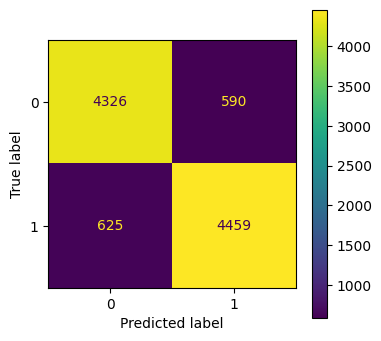

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4916
           1       0.88      0.88      0.88      5084

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

F2-Score: 0.88


In [ ]:
report(y_true, y_pred)

As we see in the report above our pretty simple linear NN is working rather well. It shows 0.88 of accuracy score on the test set, and the same F2-score.

Saving the model to Google Drive:

In [ ]:
model_save(linear_model, 'LinearNN_sentiment')

Saving model to: /content/drive/MyDrive/ds_data//LinearNN_sentiment


## LSTM neural network:

### Defining Dataloaders:

I used TfIdf encoded data while training the linear model. This time I will use text records encoded using the vocabulary on the satge of data preparation. The whole corpus of encoded texts contains in 'features' list:

In [ ]:
X, y = features, df['sentiment'].values

In [ ]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=.4, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=.5, shuffle=True)

In [ ]:
#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data=TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_data=TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

#dataloader
batch_size=100
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

Analyzing the dataloader data to check its consistency and dimensionalities:

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([100, 400])
Sample input: 
 tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0570e+03, 6.6000e+01,
         1.4300e+02],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.0000e+00, 5.8000e+01,
         2.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 2.0000e+00, 3.0800e+02,
         2.7000e+01],
        ...,
        [2.4360e+03, 5.6120e+03, 9.3000e+01,  ..., 3.1800e+02, 4.0000e+00,
         4.1280e+03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+01, 6.9000e+01,
         2.2830e+03],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.4100e+02, 1.2000e+03,
         1.4433e+04]])
Sample label size:  torch.Size([100])
Sample label: 
 tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,

### Defining the LSTM model:

Long Short-Term Memory (LSTM) networks is a kind of RNN model that deals with the vanishing gradient problem. It learns to keep the relevant content of the sentence and forget the non relevant ones based on training. This model preserves gradients over time using dynamic gates that are called memory cells. At each input state, a gate can erase, write and read information from the memory cell. Gate values are computed based on linear combinations of the current input and the previous state.

In [ ]:
class SentimentalLSTM(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim

        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        #dropout layer
        self.dropout=nn.Dropout(0.3)

        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()

        #Embadding and LSTM output
        embedd=self.embedding(x.long())
        lstm_out, hidden=self.lstm(embedd, hidden)

        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)

        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)

        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]

        return sig_out, hidden

    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))


        return hidden

Instantiating the model and defining hyperparams:

In [ ]:
vocab_size = len(vocab)
output_size = 1
embedding_dim = 80
hidden_dim = 256
n_layers = 2

lstm_model = SentimentalLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
lstm_model.to(device)
print(lstm_model)

SentimentalLSTM(
  (embedding): Embedding(50000, 80)
  (lstm): LSTM(80, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

Defining the function that performs all the training process. Here I've implemented early stopping which interrupts the training loop in case of the validation accuracy not improving during a few epochs. The check is performed after every epoch. The function returns four lists with losses and accuracies for both train and validation processes to further use them for plotting learning curves.

In [ ]:
def lstm_train(model, train_loader, val_loader, epochs):
  # training params

  counter = 0
  print_every = 100
  clip=5 # gradient clipping

  train_losses_ext = []
  train_accs_ext = []
  val_losses_ext = []
  val_accs_ext = []

  early_stop_thresh = 1
  best_loss = 9999999
  best_epoch = -1

  model.train()
  # train for some number of epochs
  for e in range(epochs):
      # initialize hidden state
      h = model.init_hidden(batch_size)

      train_losses = []
      train_accs = []
      epoch_val_loss = []

      # batch loop
      for i, data in tqdm(enumerate(train_loader), total = len(train_loader)):
          inputs, labels = data
          counter += 1
          inputs=inputs.to(device)
          labels=labels.to(device)
          # Creating new variables for the hidden state, otherwise
          # we'd backprop through the entire training history
          h = tuple([each.data for each in h])

          # zero accumulated gradients
          model.zero_grad()

          # get the output from the model
          output, h = model(inputs, h)
          #print(torch.round(output))
          #print(labels)
          acc = accuracy(torch.round(output), labels)
          train_accs.append(acc.detach().cpu().float())
          # calculate the loss and perform backprop
          loss = criterion(output.squeeze(), labels.float())
          train_losses.append(loss.detach().cpu().float())

          loss.backward()
          # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
          nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()

          # loss stats
          if counter % print_every == 0:
              # Get validation loss
              val_h = model.init_hidden(batch_size)
              val_losses = []
              val_accs = []
              model.eval()
              for inputs, labels in val_loader:

                  # Creating new variables for the hidden state, otherwise
                  # we'd backprop through the entire training history
                  val_h = tuple([each.data for each in val_h])

                  inputs, labels = inputs.cuda(), labels.cuda()
                  output, val_h = model(inputs, val_h)
                  val_acc = accuracy(torch.round(output), labels).cpu().float()
                  val_loss = criterion(output.squeeze(), labels.float())
                  val_accs.append(val_acc)
                  val_losses.append(val_loss.item())

              model.train()
              val_losses_ext.append(np.mean(val_losses))
              #print(val_accs)
              val_accs_ext.append(np.mean(val_accs))
              train_losses_ext.append(np.mean(train_losses))
              train_accs_ext.append(np.mean(train_accs))

              print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Train Loss: {:.4f}...".format(np.mean(train_losses)), # loss.item()
                    "Train Accuracy: {:.4f}...".format(np.mean(train_accs)),
                    "Val Loss: {:.4f}...".format(np.mean(val_losses)),
                    "Val Accuracy: {:.4f}".format(np.mean(val_accs)))
              epoch_val_loss.append(np.mean(val_losses))
              train_losses = []
              train_accs = []

      # Early stopping:
      ep_loss = np.mean(epoch_val_loss)
      print(f"End of epoch {e+1}: loss = {ep_loss:.2f}")
      if ep_loss < best_loss:
          best_loss = ep_loss
          best_epoch = e

      elif e - best_epoch > early_stop_thresh:
          print("Early stopped training at epoch ", str(e+1))
          break  # terminate the training loop

  return train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext

In [ ]:
train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext = lstm_train(lstm_model, train_loader, val_loader, 10)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/10... Step: 100... Train Loss: 0.6369... Train Accuracy: 0.6284... Val Loss: 0.5732... Val Accuracy: 0.7175
Epoch: 1/10... Step: 200... Train Loss: 0.5717... Train Accuracy: 0.7130... Val Loss: 0.5213... Val Accuracy: 0.7463
Epoch: 1/10... Step: 300... Train Loss: 0.5438... Train Accuracy: 0.7407... Val Loss: 0.4637... Val Accuracy: 0.7863
End of epoch 1: loss = 0.52


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2/10... Step: 400... Train Loss: 0.4816... Train Accuracy: 0.7855... Val Loss: 0.4972... Val Accuracy: 0.7937
Epoch: 2/10... Step: 500... Train Loss: 0.4468... Train Accuracy: 0.8084... Val Loss: 0.4183... Val Accuracy: 0.8180
Epoch: 2/10... Step: 600... Train Loss: 0.4275... Train Accuracy: 0.8205... Val Loss: 0.4012... Val Accuracy: 0.8265
End of epoch 2: loss = 0.44


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3/10... Step: 700... Train Loss: 0.3543... Train Accuracy: 0.8546... Val Loss: 0.4353... Val Accuracy: 0.8249
Epoch: 3/10... Step: 800... Train Loss: 0.3474... Train Accuracy: 0.8630... Val Loss: 0.3639... Val Accuracy: 0.8508
Epoch: 3/10... Step: 900... Train Loss: 0.3474... Train Accuracy: 0.8589... Val Loss: 0.3617... Val Accuracy: 0.8436
End of epoch 3: loss = 0.39


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4/10... Step: 1000... Train Loss: 0.2828... Train Accuracy: 0.8904... Val Loss: 0.3633... Val Accuracy: 0.8544
Epoch: 4/10... Step: 1100... Train Loss: 0.2870... Train Accuracy: 0.8888... Val Loss: 0.3686... Val Accuracy: 0.8474
Epoch: 4/10... Step: 1200... Train Loss: 0.2762... Train Accuracy: 0.8959... Val Loss: 0.3486... Val Accuracy: 0.8552
End of epoch 4: loss = 0.36


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5/10... Step: 1300... Train Loss: 0.2279... Train Accuracy: 0.9178... Val Loss: 0.3646... Val Accuracy: 0.8598
Epoch: 5/10... Step: 1400... Train Loss: 0.2360... Train Accuracy: 0.9158... Val Loss: 0.3720... Val Accuracy: 0.8564
Epoch: 5/10... Step: 1500... Train Loss: 0.2293... Train Accuracy: 0.9200... Val Loss: 0.4587... Val Accuracy: 0.8562
End of epoch 5: loss = 0.40


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6/10... Step: 1600... Train Loss: 0.1825... Train Accuracy: 0.9350... Val Loss: 0.4133... Val Accuracy: 0.8607
Epoch: 6/10... Step: 1700... Train Loss: 0.1900... Train Accuracy: 0.9324... Val Loss: 0.3745... Val Accuracy: 0.8661
Epoch: 6/10... Step: 1800... Train Loss: 0.2045... Train Accuracy: 0.9312... Val Loss: 0.3788... Val Accuracy: 0.8477
End of epoch 6: loss = 0.39
Early stopped training at epoch  6


As we can see early stopping algorithm works - the training process has been stopped after 6 epochs but 10 epochs have been set initially though. Let's see how training curves for this model looks like:

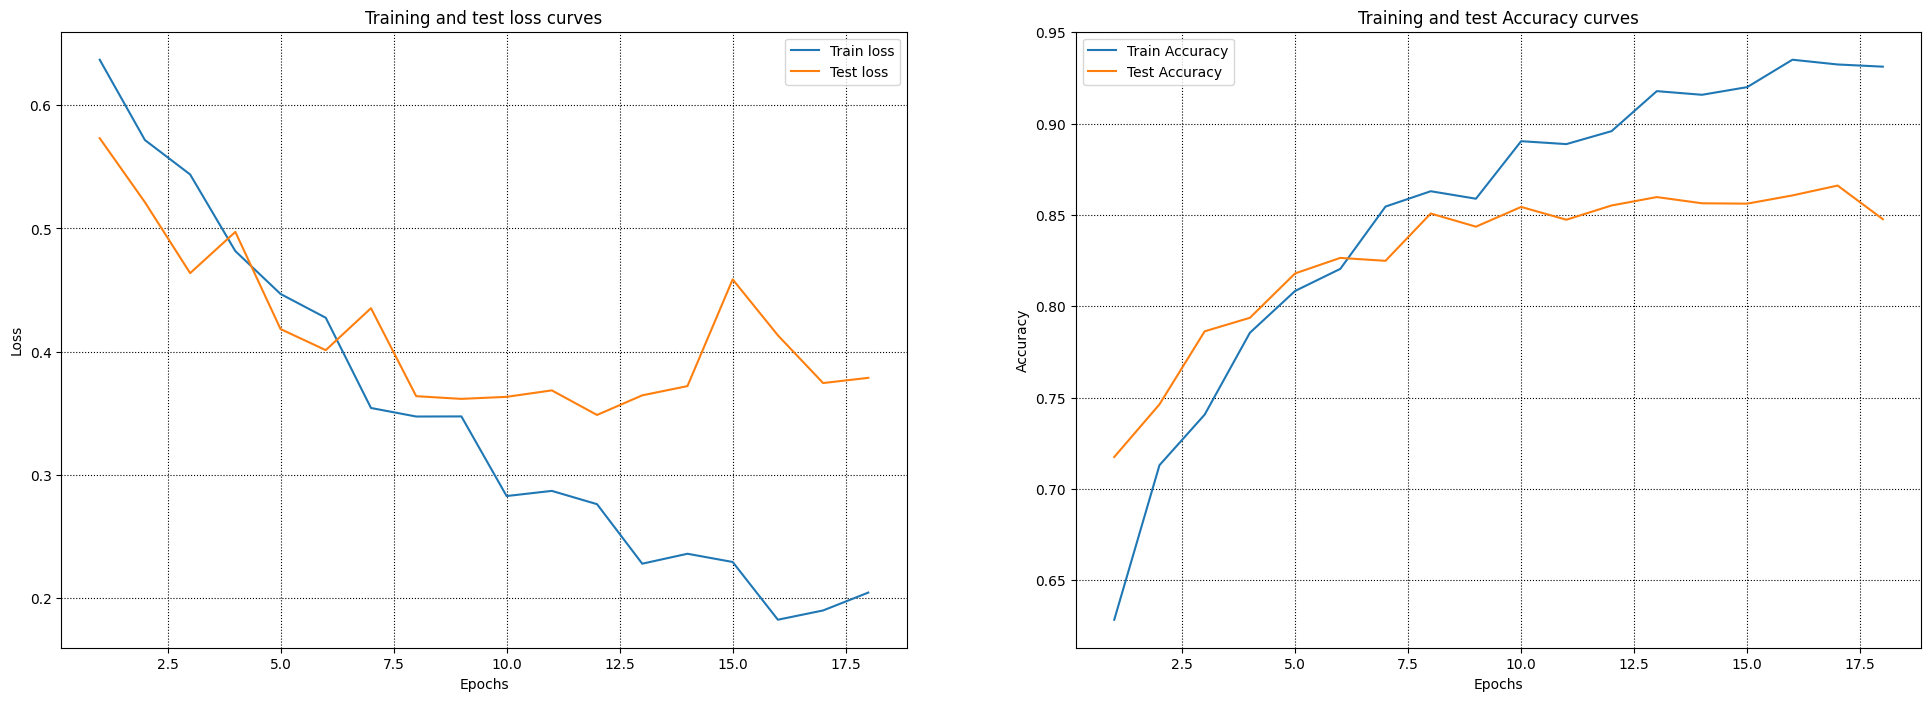

In [ ]:
plot_train_progress(train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext, 18)

Defining the function that would evaluate the model by getting predictions from the training set:

In [ ]:
def test_model(model, iterator):
  test_losses = [] # track loss
  num_correct = 0
  grnd_true = []
  predictions = []

  # init hidden state
  h = model.init_hidden(batch_size)

  model.eval()
  # iterate over test data
  for inputs, labels in iterator:
    grnd_true.extend(labels)
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training histor
    h = tuple([each.data for each in h])

    inputs, labels = inputs.to(device), labels.to(device)


    output, h = model(inputs, h)

          # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    predictions.extend(pred.cpu().detach().numpy())
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device=='cpu' else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

  # -- stats! -- ##
  # avg test loss
  print("Test loss: {:.3f}".format(np.mean(test_losses)))

  # accuracy over all test data
  test_acc = num_correct/len(iterator.dataset)
  print("Test accuracy: {:.3f}".format(test_acc))
  return grnd_true, predictions

In [ ]:
grnd_true, predictions = test_model(lstm_model, test_loader)

Test loss: 0.369
Test accuracy: 0.852


Displaying the confusion matrix and classification report:

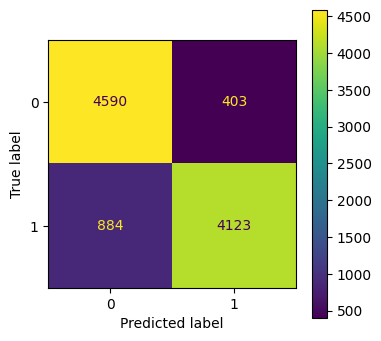

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      4993
         1.0       0.91      0.82      0.86      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

F2-Score: 0.84


In [ ]:
report(grnd_true, predictions)

Saving the model:

In [ ]:
model_save(lstm_model, 'LSTM_sentiment')

Saving model to: /content/drive/MyDrive/ds_data//LSTM_sentiment


Let's make a function to predict sentiment for given sentence and then try it:

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    h = model.init_hidden(1)

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    encoded_sample = encode_corpus(tokenized, vocab)
    encoded_sample = np.array(encoded_sample).flatten()
    encoded_sample = encoded_sample.tolist()
    feature = corpus_padding(encoded_sample, 400)
    tensor = torch.LongTensor(feature).to(device)
    tensor = tensor.view(1,400)

    proba = model(tensor, h)[0]
    prediction = torch.round(proba)
    result = 'Positive' if prediction==1 else 'Negative'
    print(result)
    print('Prediction probability: ', "%.2f" % float(proba.detach().cpu().numpy()))

In [ ]:
predict_sentiment(lstm_model, 'I love this amazing film')

Positive
Prediction probability:  0.92


In [ ]:
predict_sentiment(lstm_model, 'I was dissapointed about this film')

Negative
Prediction probability:  0.35


Seems it works quite well.

#Train Word2Vec model

To enhance my LSTM model I will am going to train the Word2Vec model, get embeddings for words from our vocabulary from it, and then use these embeddings in the model. Probably this might improve the predictive performance of the LSTM model.

Tokenizing all texts:

In [ ]:
tokenized_texts = [word_tokenize(text) for text in texts]

In [ ]:
print([' '.join(row) for row in tokenized_texts[:1]])

['one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy not high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due l

Defining hypers and instantiating Word2Vec model from the gensim library:

In [ ]:
W2V_WINDOW = 5
W2V_EPOCH = 100
W2V_MIN_COUNT = 5
VECTOR_SIZE = 300
# Train Word Embeddings and save
w2v_model = gensim.models.word2vec.Word2Vec(tokenized_texts, vector_size=VECTOR_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT).wv

Let's try how does the model work by selecting the most similar words to the given words:

In [ ]:
w2v_model.most_similar('film')

[('movie', 0.7499990463256836),
 ('films', 0.5854454040527344),
 ('documentary', 0.5405827760696411),
 ('flick', 0.535625159740448),
 ('picture', 0.4917711019515991),
 ('cinema', 0.47273918986320496),
 ('nevertheless', 0.4726143777370453),
 ('masterpiece', 0.4671266973018646),
 ('thriller', 0.45577722787857056),
 ('considering', 0.44254279136657715)]

In [ ]:
w2v_model.most_similar('director')

[('filmmaker', 0.673581063747406),
 ('directors', 0.6160927414894104),
 ('directorial', 0.5009526610374451),
 ('producer', 0.4841073751449585),
 ('filmmakers', 0.4807364046573639),
 ('directed', 0.4763941466808319),
 ('altman', 0.47416141629219055),
 ('cinematographer', 0.47305798530578613),
 ('schumacher', 0.4671575129032135),
 ('harlin', 0.4634228050708771)]

Adding special tokens into the W2V embeddings:

In [ ]:
w2v_model["<unk>"] = np.random.rand(300)
w2v_model["<pad>"] = np.random.rand(300)

In [ ]:
w2v_model.get_index("<unk>")

39120

In [ ]:
w2v_model.get_index("<pad>")

39121

Taking embeddings from the W2V model:

In [ ]:
w2v = w2v_model.vectors

In [ ]:
w2v.shape

(39122, 300)

Taking the vocabulary from the W2V model. We'll starting indexing words from 2 keeping 0 and 1 for special tokens. This is so that we can use the existing functions for encoding and padding:

In [ ]:
w2v_map = {
    word:idx
    for idx,word in enumerate(w2v_model.key_to_index, start=2)
}
w2v_map

{'movie': 2,
 'film': 3,
 'not': 4,
 'one': 5,
 'like': 6,
 'good': 7,
 'no': 8,
 'time': 9,
 'even': 10,
 'would': 11,
 'story': 12,
 'really': 13,
 'see': 14,
 'well': 15,
 'much': 16,
 'bad': 17,
 'get': 18,
 'people': 19,
 'great': 20,
 'also': 21,
 'first': 22,
 'made': 23,
 'make': 24,
 'way': 25,
 'could': 26,
 'movies': 27,
 'characters': 28,
 'think': 29,
 'watch': 30,
 'character': 31,
 'films': 32,
 'two': 33,
 'many': 34,
 'seen': 35,
 'love': 36,
 'plot': 37,
 'never': 38,
 'life': 39,
 'acting': 40,
 'show': 41,
 'best': 42,
 'know': 43,
 'little': 44,
 'ever': 45,
 'man': 46,
 'better': 47,
 'end': 48,
 'scene': 49,
 'still': 50,
 'say': 51,
 'scenes': 52,
 'something': 53,
 'go': 54,
 'back': 55,
 'real': 56,
 'thing': 57,
 'watching': 58,
 'actors': 59,
 'director': 60,
 'years': 61,
 'funny': 62,
 'though': 63,
 'old': 64,
 'another': 65,
 'work': 66,
 'actually': 67,
 'nothing': 68,
 'makes': 69,
 'look': 70,
 'find': 71,
 'going': 72,
 'new': 73,
 'lot': 74,
 'every

Changing values for special tokens:

In [ ]:
w2v_map['<pad>'] = 1
w2v_map['<unk>'] = 0

I would like to restore the order of word embeddings according to the order of the obtained vocabulary. For this, I simply shift the numpy array with np.roll() function, which moves the two last values to the beginning of the array:

In [ ]:
w2v = np.roll(w2v, 2, axis=0)

###Visualizing Word2Vec space

As an optional exercise, I am going to visualize W2V embeddings space. For this, I will choose the first 1000 most common words:

In [ ]:
words = w2v_model.index_to_key[:1000]
word_vectors = w2v_model.vectors[[w2v_model.key_to_index[word] for word in words]]

In [ ]:
word_vectors

array([[-8.3251685e-01, -3.4335670e-01, -6.8763381e-01, ...,
         6.2831962e-01, -4.2777681e-01, -7.2914690e-01],
       [-5.2241069e-01,  7.5597095e-01, -5.5579585e-01, ...,
        -1.8124646e-01,  5.1201326e-01, -1.3421652e+00],
       [ 6.6796321e-01,  1.8211663e-01, -3.5868335e-01, ...,
         5.1835102e-01,  2.9151586e-01, -6.9188452e-01],
       ...,
       [ 8.3151102e-01,  1.9011925e-01,  7.6610774e-02, ...,
         4.9502811e-01,  4.2191234e-01, -2.0570640e-01],
       [-6.7106527e-01, -5.5323112e-01,  3.3058113e-01, ...,
        -2.9125473e-01,  6.7846435e-01, -3.9653140e-01],
       [-1.2777745e+00, -1.3109713e-03,  3.2343605e-01, ...,
        -6.4917523e-01, -6.8024218e-01, -1.0130939e+00]], dtype=float32)

I will use PCA to reduce dimensionality from 400 to 2:

In [ ]:
def get_pca_projection(word_vectors):
    pca = PCA(n_components=2)
    return pca.fit_transform(word_vectors)

In [ ]:
word_vectors_pca = get_pca_projection(word_vectors)

Plotting the interactive plot of 2D projection of W2V space:

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

In [ ]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1003', ...)

If zoom the plot and check close points (which represent words) we can notice that they are grouped by similar meaning.

###Texts embeddings

Using the following function I have also obtained the array of texts embeddings which are simply the means of the vectors of all the words they contain. But unfortunately, I couldn't manage to get decent results by feeding these embeddings into LSTM models. Need to get back to this task later.

In [ ]:
def get_phrase_embedding(model, phrase):
    tokenized = word_tokenize(phrase.lower())
    if len(tokenized) > 0:
        vector = model.get_mean_vector(tokenized)
        return vector
    return np.zeros([model.vector_size], dtype='float32')

In [ ]:
text_vectors = np.array([get_phrase_embedding(w2v_model, text) for text in texts])

In [ ]:
len(text_vectors)

50000

## LTSM model with pretrained Word2Vec embeddings

Now let's try to increase the performance of the LSTM model by adding there pre-trained W2V embeddings. First I am using previously developed functions to encode texts, and  to make them of the same length:

In [ ]:
encoded_w2v_reviews = encode_corpus(texts, w2v_map)

In [ ]:
features = corpus_padding(encoded_w2v_reviews, 400)

Defining X,y, and splitting them into three sets:

In [ ]:
X, y = features, df['sentiment'].values
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=.4, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=.5, shuffle=True)
print(f'shape of train set is {len(X_train)}')
print(f'shape of validation set is {len(X_val)}')
print(f'shape of test set is {len(X_test)}')

shape of train set is 30000
shape of validation set is 10000
shape of test set is 10000


In [ ]:
X_train

array([[    3,     6,  5000, ...,    13,     7,   174],
       [    1,     1,     1, ...,   319,    96,   857],
       [    1,     1,     1, ...,    13,  1513,  3287],
       ...,
       [    1,     1,     1, ..., 12331,   255,  1109],
       [    1,     1,     1, ...,   171,    84, 10443],
       [    1,     1,     1, ...,   212,   542,   479]])

Defining DataLoaders:

In [ ]:
#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data=TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_data=TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

#dataloader
batch_size=100
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

Defining the LSTM model:

In [ ]:
class SentimentalLSTMwEmbeddings(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim

        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        #dropout layer
        self.dropout=nn.Dropout(0.3)

        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()

        #Embadding and LSTM output
        embedd=self.embedding(x.long())
        lstm_out, hidden=self.lstm(embedd, hidden)

        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)

        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)

        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]

        return sig_out, hidden

    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))


        return hidden

Choose hypers and instantiating the model:

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(w2v_map)
output_size = 1
embedding_dim = 300
hidden_dim = 120
n_layers = 2

lstm_w2v_model = SentimentalLSTMwEmbeddings(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
lstm_w2v_model.to(device)
print(lstm_w2v_model)

SentimentalLSTMwEmbeddings(
  (embedding): Embedding(39122, 300)
  (lstm): LSTM(300, 120, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=120, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Defining the loss function and the optimizer:

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_w2v_model.parameters(), lr=lr)


Adding pre-trained embeddings into the embedding layer of the model. Forbidding to change these weights by gradient descent:

In [ ]:
# The shape of the embedding_matrix must be (vocab_size, embedding_dim)
lstm_w2v_model.embedding.weight.data.copy_(torch.from_numpy(w2v))

# Make sure that the weights in the embedding layer are not updated
lstm_w2v_model.embedding.weight.requires_grad=False

Training process:

In [ ]:
train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext = lstm_train(lstm_w2v_model, train_loader, val_loader, 10)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/10... Step: 100... Train Loss: 0.5116... Train Accuracy: 0.7596... Val Loss: 0.3830... Val Accuracy: 0.8370
Epoch: 1/10... Step: 200... Train Loss: 0.3947... Train Accuracy: 0.8350... Val Loss: 0.3536... Val Accuracy: 0.8480
Epoch: 1/10... Step: 300... Train Loss: 0.3509... Train Accuracy: 0.8585... Val Loss: 0.3738... Val Accuracy: 0.8350
End of epoch 1: accuracy = 0.84


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2/10... Step: 400... Train Loss: 0.3437... Train Accuracy: 0.8620... Val Loss: 0.3528... Val Accuracy: 0.8592
Epoch: 2/10... Step: 500... Train Loss: 0.3484... Train Accuracy: 0.8559... Val Loss: 0.3364... Val Accuracy: 0.8651
Epoch: 2/10... Step: 600... Train Loss: 0.3308... Train Accuracy: 0.8647... Val Loss: 0.3032... Val Accuracy: 0.8761
End of epoch 2: accuracy = 0.87


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3/10... Step: 700... Train Loss: 0.3037... Train Accuracy: 0.8738... Val Loss: 0.3499... Val Accuracy: 0.8682
Epoch: 3/10... Step: 800... Train Loss: 0.2844... Train Accuracy: 0.8913... Val Loss: 0.2956... Val Accuracy: 0.8826
Epoch: 3/10... Step: 900... Train Loss: 0.3104... Train Accuracy: 0.8779... Val Loss: 0.2957... Val Accuracy: 0.8768
End of epoch 3: accuracy = 0.88


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4/10... Step: 1000... Train Loss: 0.2873... Train Accuracy: 0.8841... Val Loss: 0.3637... Val Accuracy: 0.8513
Epoch: 4/10... Step: 1100... Train Loss: 0.2663... Train Accuracy: 0.8922... Val Loss: 0.2827... Val Accuracy: 0.8854
Epoch: 4/10... Step: 1200... Train Loss: 0.2729... Train Accuracy: 0.8925... Val Loss: 0.2894... Val Accuracy: 0.8784
End of epoch 4: accuracy = 0.87


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5/10... Step: 1300... Train Loss: 0.2507... Train Accuracy: 0.9038... Val Loss: 0.2669... Val Accuracy: 0.8923
Epoch: 5/10... Step: 1400... Train Loss: 0.2594... Train Accuracy: 0.8988... Val Loss: 0.2807... Val Accuracy: 0.8807
Epoch: 5/10... Step: 1500... Train Loss: 0.2491... Train Accuracy: 0.9037... Val Loss: 0.2816... Val Accuracy: 0.8904
End of epoch 5: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6/10... Step: 1600... Train Loss: 0.2341... Train Accuracy: 0.9113... Val Loss: 0.2750... Val Accuracy: 0.8863
Epoch: 6/10... Step: 1700... Train Loss: 0.2407... Train Accuracy: 0.9058... Val Loss: 0.2793... Val Accuracy: 0.8887
Epoch: 6/10... Step: 1800... Train Loss: 0.2492... Train Accuracy: 0.9030... Val Loss: 0.2974... Val Accuracy: 0.8741
End of epoch 6: accuracy = 0.88


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7/10... Step: 1900... Train Loss: 0.2240... Train Accuracy: 0.9137... Val Loss: 0.2692... Val Accuracy: 0.8927
Epoch: 7/10... Step: 2000... Train Loss: 0.2208... Train Accuracy: 0.9165... Val Loss: 0.2749... Val Accuracy: 0.8833
Epoch: 7/10... Step: 2100... Train Loss: 0.2223... Train Accuracy: 0.9140... Val Loss: 0.2840... Val Accuracy: 0.8894
End of epoch 7: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8/10... Step: 2200... Train Loss: 0.1992... Train Accuracy: 0.9228... Val Loss: 0.2906... Val Accuracy: 0.8887
Epoch: 8/10... Step: 2300... Train Loss: 0.1938... Train Accuracy: 0.9245... Val Loss: 0.2785... Val Accuracy: 0.8904
Epoch: 8/10... Step: 2400... Train Loss: 0.2199... Train Accuracy: 0.9148... Val Loss: 0.2671... Val Accuracy: 0.8915
End of epoch 8: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 9/10... Step: 2500... Train Loss: 0.1822... Train Accuracy: 0.9335... Val Loss: 0.2803... Val Accuracy: 0.8905
Epoch: 9/10... Step: 2600... Train Loss: 0.1975... Train Accuracy: 0.9234... Val Loss: 0.2930... Val Accuracy: 0.8899
Epoch: 9/10... Step: 2700... Train Loss: 0.1882... Train Accuracy: 0.9245... Val Loss: 0.2778... Val Accuracy: 0.8906
End of epoch 9: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10/10... Step: 2800... Train Loss: 0.1534... Train Accuracy: 0.9428... Val Loss: 0.3275... Val Accuracy: 0.8931
Epoch: 10/10... Step: 2900... Train Loss: 0.1836... Train Accuracy: 0.9312... Val Loss: 0.3018... Val Accuracy: 0.8926
Epoch: 10/10... Step: 3000... Train Loss: 0.1726... Train Accuracy: 0.9355... Val Loss: 0.2921... Val Accuracy: 0.8816
End of epoch 10: accuracy = 0.89


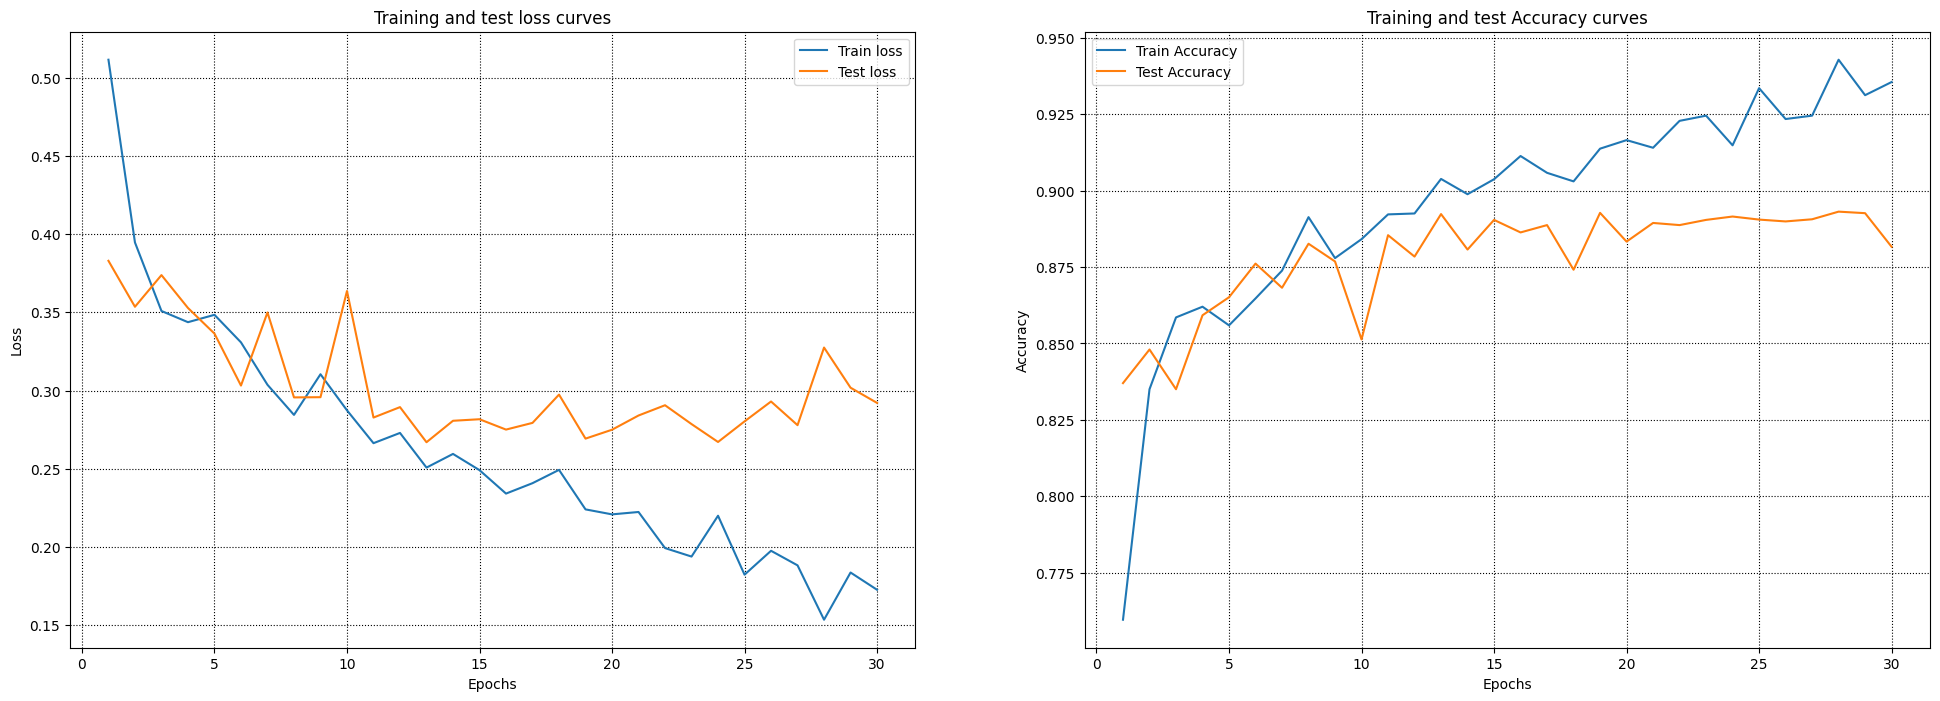

In [ ]:
plot_train_progress(train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext, 30)

In [ ]:
grnd_true, predictions = test_model(lstm_w2v_model, test_loader)

Test loss: 0.279
Test accuracy: 0.886


As we can see the performance of the model has improved significantly. Accuracy now is 0.89 instead of the 0.85 that I obtained from the clear LSTM model.

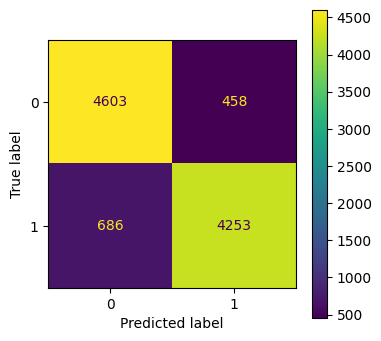

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      5061
         1.0       0.90      0.86      0.88      4939

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

F2-Score: 0.87


In [ ]:
report(grnd_true, predictions)

In [ ]:
model_save(lstm_w2v_model, 'LSTM_W2V_sentiment_v1')

Saving model to: /content/drive/MyDrive/ds_data//LSTM_W2V_sentiment_v1


### LSTM with 4 layers

Another experiment - now I'll try to increase the number of LSTM layers in my model and see if this could improve metrics.

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(w2v_map)
output_size = 1
embedding_dim = 300
hidden_dim = 150
n_layers = 4

lstm_w2v_model_v2 = SentimentalLSTMwEmbeddings(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
lstm_w2v_model_v2.to(device)
print(lstm_w2v_model_v2)

SentimentalLSTMwEmbeddings(
  (embedding): Embedding(39122, 300)
  (lstm): LSTM(300, 150, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=150, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_w2v_model_v2.parameters(), lr=lr)

In [ ]:
# The shape of the embedding_matrix must be (vocab_size, embedding_dim)
lstm_w2v_model_v2.embedding.weight.data.copy_(torch.from_numpy(w2v))

# Make sure that the weights in the embedding layer are not updated
lstm_w2v_model_v2.embedding.weight.requires_grad=False

In [ ]:
train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext = lstm_train(lstm_w2v_model_v2, train_loader, val_loader, 8)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/8... Step: 100... Train Loss: 0.5602... Train Accuracy: 0.7204... Val Loss: 0.4872... Val Accuracy: 0.7845
Epoch: 1/8... Step: 200... Train Loss: 0.4927... Train Accuracy: 0.8015... Val Loss: 0.4583... Val Accuracy: 0.8159
Epoch: 1/8... Step: 300... Train Loss: 0.4765... Train Accuracy: 0.8112... Val Loss: 0.3945... Val Accuracy: 0.8317
End of epoch 1: accuracy = 0.81


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2/8... Step: 400... Train Loss: 0.4292... Train Accuracy: 0.8292... Val Loss: 0.4314... Val Accuracy: 0.8132
Epoch: 2/8... Step: 500... Train Loss: 0.3905... Train Accuracy: 0.8389... Val Loss: 0.3406... Val Accuracy: 0.8612
Epoch: 2/8... Step: 600... Train Loss: 0.3530... Train Accuracy: 0.8577... Val Loss: 0.3316... Val Accuracy: 0.8668
End of epoch 2: accuracy = 0.85


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3/8... Step: 700... Train Loss: 0.3339... Train Accuracy: 0.8662... Val Loss: 0.3573... Val Accuracy: 0.8653
Epoch: 3/8... Step: 800... Train Loss: 0.3442... Train Accuracy: 0.8601... Val Loss: 0.3039... Val Accuracy: 0.8746
Epoch: 3/8... Step: 900... Train Loss: 0.3102... Train Accuracy: 0.8744... Val Loss: 0.3146... Val Accuracy: 0.8628
End of epoch 3: accuracy = 0.87


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4/8... Step: 1000... Train Loss: 0.2977... Train Accuracy: 0.8785... Val Loss: 0.2931... Val Accuracy: 0.8798
Epoch: 4/8... Step: 1100... Train Loss: 0.2855... Train Accuracy: 0.8891... Val Loss: 0.2879... Val Accuracy: 0.8809
Epoch: 4/8... Step: 1200... Train Loss: 0.3002... Train Accuracy: 0.8825... Val Loss: 0.2837... Val Accuracy: 0.8850
End of epoch 4: accuracy = 0.88


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5/8... Step: 1300... Train Loss: 0.2943... Train Accuracy: 0.8847... Val Loss: 0.3101... Val Accuracy: 0.8773
Epoch: 5/8... Step: 1400... Train Loss: 0.2793... Train Accuracy: 0.8881... Val Loss: 0.2897... Val Accuracy: 0.8841
Epoch: 5/8... Step: 1500... Train Loss: 0.2733... Train Accuracy: 0.8863... Val Loss: 0.2879... Val Accuracy: 0.8873
End of epoch 5: accuracy = 0.88


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6/8... Step: 1600... Train Loss: 0.2711... Train Accuracy: 0.8931... Val Loss: 0.2850... Val Accuracy: 0.8822
Epoch: 6/8... Step: 1700... Train Loss: 0.2584... Train Accuracy: 0.8941... Val Loss: 0.2672... Val Accuracy: 0.8904
Epoch: 6/8... Step: 1800... Train Loss: 0.2594... Train Accuracy: 0.9008... Val Loss: 0.2666... Val Accuracy: 0.8904
End of epoch 6: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7/8... Step: 1900... Train Loss: 0.2418... Train Accuracy: 0.9079... Val Loss: 0.2785... Val Accuracy: 0.8927
Epoch: 7/8... Step: 2000... Train Loss: 0.2545... Train Accuracy: 0.8979... Val Loss: 0.2655... Val Accuracy: 0.8947
Epoch: 7/8... Step: 2100... Train Loss: 0.2677... Train Accuracy: 0.8937... Val Loss: 0.2764... Val Accuracy: 0.8867
End of epoch 7: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8/8... Step: 2200... Train Loss: 0.2380... Train Accuracy: 0.9068... Val Loss: 0.2755... Val Accuracy: 0.8923
Epoch: 8/8... Step: 2300... Train Loss: 0.2332... Train Accuracy: 0.9105... Val Loss: 0.2703... Val Accuracy: 0.8874
Epoch: 8/8... Step: 2400... Train Loss: 0.2424... Train Accuracy: 0.9062... Val Loss: 0.2723... Val Accuracy: 0.8924
End of epoch 8: accuracy = 0.89


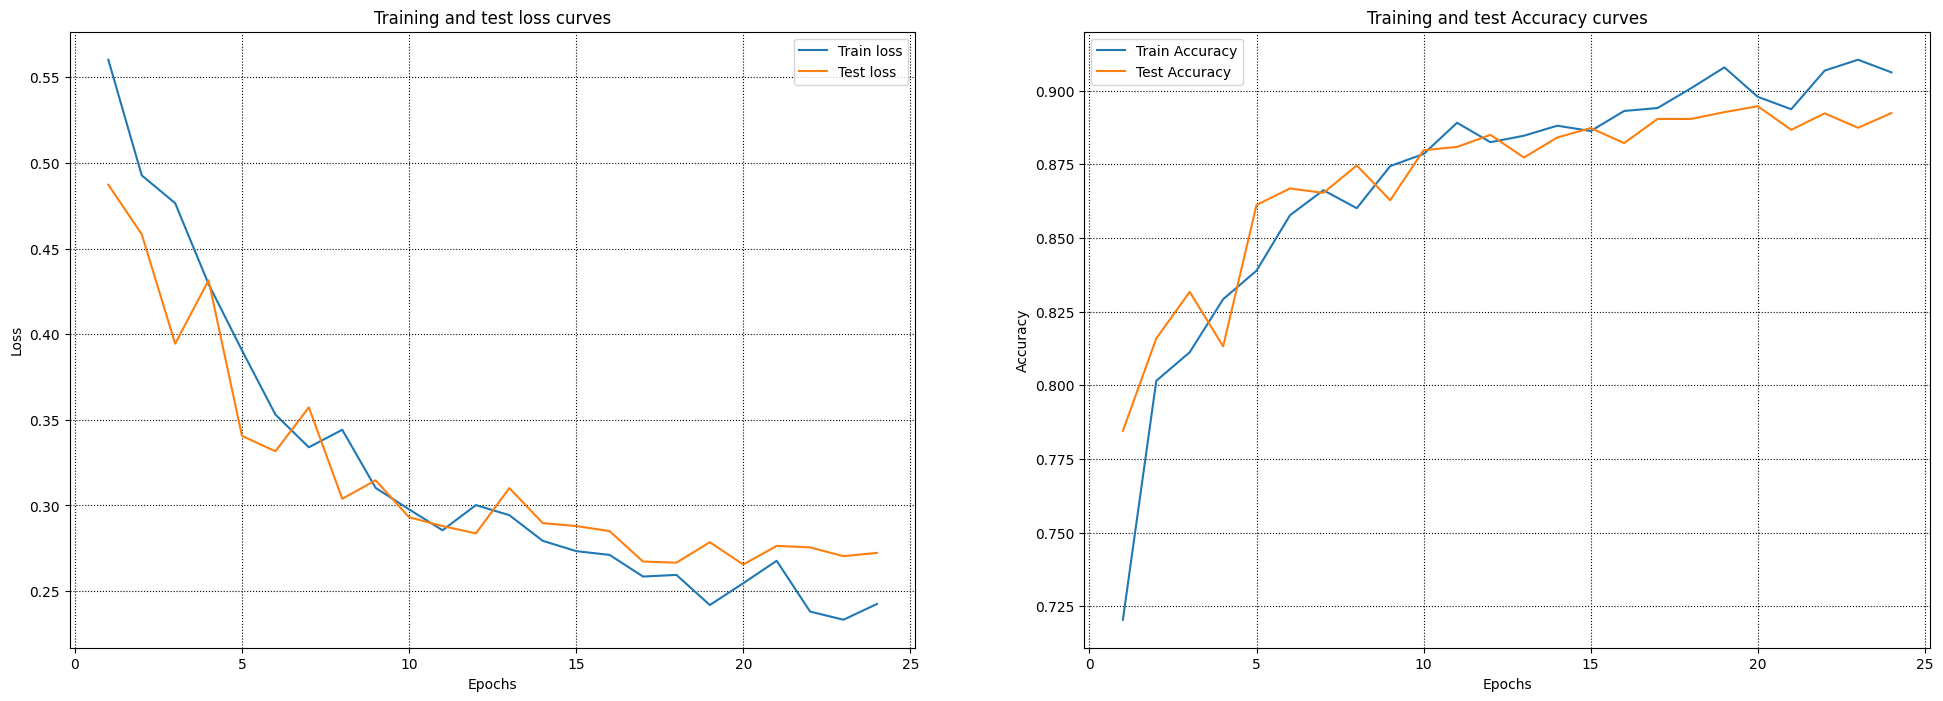

In [ ]:
plot_train_progress(train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext, 24)

In [ ]:
grnd_true, predictions = test_model(lstm_w2v_model_v2, test_loader)

Test loss: 0.266
Test accuracy: 0.899


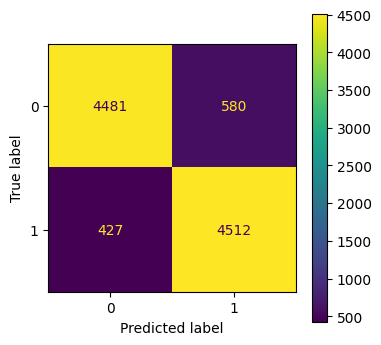

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      5061
         1.0       0.89      0.91      0.90      4939

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

F2-Score: 0.91


In [ ]:
report(grnd_true, predictions)

Metrics were slightly improved. **Accuracy = 0.9, F2-score = 0.91**

### LSTM model trained on W2V text embeddings

This is the experiment where I tried to feed phrase (text) embeddings into the LSTM model, but it didn't give any good results:

In [ ]:
X, y = text_vectors, df['sentiment'].values
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=.4, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=.5, shuffle=True)
print(f'shape of train set is {len(X_train)}')
print(f'shape of validation set is {len(X_val)}')
print(f'shape of test set is {len(X_test)}')

shape of train set is 30000
shape of validation set is 10000
shape of test set is 10000


In [ ]:
#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data=TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_data=TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

#dataloader
batch_size=100
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(w2v_map)
output_size = 1
embedding_dim = 300
hidden_dim = 100
n_layers = 2

lstm_w2v_model_v3 = SentimentalLSTMwEmbeddings(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
lstm_w2v_model_v3.to(device)
print(lstm_w2v_model_v3)

SentimentalLSTMwEmbeddings(
  (embedding): Embedding(39122, 300)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_w2v_model_v3.parameters(), lr=lr)

In [ ]:
# The shape of the embedding_matrix must be (vocab_size, embedding_dim)
lstm_w2v_model_v3.embedding.weight.data.copy_(torch.from_numpy(w2v))

# Make sure that the weights in the embedding layer are not updated
lstm_w2v_model_v3.embedding.weight.requires_grad=False

In [ ]:
train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext = lstm_train(lstm_w2v_model_v3, train_loader, val_loader, 8)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/8... Step: 100... Train Loss: 0.6949... Train Accuracy: 0.5028... Val Loss: 0.6933... Val Accuracy: 0.4977
Epoch: 1/8... Step: 200... Train Loss: 0.6937... Train Accuracy: 0.4983... Val Loss: 0.6935... Val Accuracy: 0.5023
Epoch: 1/8... Step: 300... Train Loss: 0.6942... Train Accuracy: 0.4906... Val Loss: 0.6937... Val Accuracy: 0.4977
End of epoch 1: accuracy = 0.50


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2/8... Step: 400... Train Loss: 0.6936... Train Accuracy: 0.5040... Val Loss: 0.6932... Val Accuracy: 0.5023
Epoch: 2/8... Step: 500... Train Loss: 0.6933... Train Accuracy: 0.4975... Val Loss: 0.6937... Val Accuracy: 0.4977
Epoch: 2/8... Step: 600... Train Loss: 0.6932... Train Accuracy: 0.5047... Val Loss: 0.6937... Val Accuracy: 0.4977
End of epoch 2: accuracy = 0.50


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3/8... Step: 700... Train Loss: 0.6935... Train Accuracy: 0.4995... Val Loss: 0.6931... Val Accuracy: 0.5023
Epoch: 3/8... Step: 800... Train Loss: 0.6935... Train Accuracy: 0.5031... Val Loss: 0.6934... Val Accuracy: 0.4977
Epoch: 3/8... Step: 900... Train Loss: 0.6931... Train Accuracy: 0.5054... Val Loss: 0.6940... Val Accuracy: 0.4977
End of epoch 3: accuracy = 0.50


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4/8... Step: 1000... Train Loss: 0.6937... Train Accuracy: 0.5014... Val Loss: 0.6933... Val Accuracy: 0.4977
Epoch: 4/8... Step: 1100... Train Loss: 0.6935... Train Accuracy: 0.4955... Val Loss: 0.6932... Val Accuracy: 0.4977
Epoch: 4/8... Step: 1200... Train Loss: 0.6932... Train Accuracy: 0.5051... Val Loss: 0.6931... Val Accuracy: 0.5023
End of epoch 4: accuracy = 0.50
Early stopped training at epoch %d 4


Actually, I tried to do this with the Linear model also and this gave better results than 0.5 accuracy like here, but not perfect so I deleted this part of the code.

## Bi-directional LSTM

The last experiment with RNN (LSTM) models - Bi-directional LSTM.

Bidirectional LSTM (BiLSTM) model maintains two separate states for forward and backward inputs that are generated by two different LSTMs. The first LSTM is a regular sequence that starts from the beginning of the sentence, while in the second LSTM, the input sequence are fed in the opposite order. The idea behind bi-directional network is to capture information of surrounding inputs.

In [ ]:
class BiDiLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=True, drop_prob=0.5):
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim

        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, bidirectional= bidirectional, batch_first=True)

        #dropout layer
        self.dropout=nn.Dropout(0.3)

        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()

        #Embadding and LSTM output
        embedd=self.embedding(x.long())
        lstm_out, hidden=self.lstm(embedd, hidden)

        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)

        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)

        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]

        return sig_out, hidden

    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))


        return hidden

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(w2v_map)
output_size = 1
embedding_dim = 300
hidden_dim = 128
n_layers = 2

bidi_lstm_w2v_model = BiDiLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
bidi_lstm_w2v_model.to(device)
print(bidi_lstm_w2v_model)

BiDiLSTM(
  (embedding): Embedding(39122, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(bidi_lstm_w2v_model.parameters(), lr=lr)

Adding embeddings:

In [ ]:
# The shape of the embedding_matrix must be (vocab_size, embedding_dim)
bidi_lstm_w2v_model.embedding.weight.data.copy_(torch.from_numpy(w2v))

# Make sure that the weights in the embedding layer are not updated
bidi_lstm_w2v_model.embedding.weight.requires_grad=False

In [ ]:
train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext = lstm_train(bidi_lstm_w2v_model, train_loader, val_loader, 10)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/10... Step: 100... Train Loss: 0.4902... Train Accuracy: 0.7681... Val Loss: 0.3985... Val Accuracy: 0.8341
Epoch: 1/10... Step: 200... Train Loss: 0.4145... Train Accuracy: 0.8296... Val Loss: 0.3626... Val Accuracy: 0.8539
Epoch: 1/10... Step: 300... Train Loss: 0.3715... Train Accuracy: 0.8471... Val Loss: 0.3521... Val Accuracy: 0.8499
End of epoch 1: accuracy = 0.85


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 2/10... Step: 400... Train Loss: 0.3261... Train Accuracy: 0.8729... Val Loss: 0.3174... Val Accuracy: 0.8744
Epoch: 2/10... Step: 500... Train Loss: 0.3118... Train Accuracy: 0.8730... Val Loss: 0.3076... Val Accuracy: 0.8754
Epoch: 2/10... Step: 600... Train Loss: 0.3199... Train Accuracy: 0.8698... Val Loss: 0.3023... Val Accuracy: 0.8790
End of epoch 2: accuracy = 0.88


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 3/10... Step: 700... Train Loss: 0.2909... Train Accuracy: 0.8879... Val Loss: 0.3213... Val Accuracy: 0.8746
Epoch: 3/10... Step: 800... Train Loss: 0.2912... Train Accuracy: 0.8813... Val Loss: 0.3029... Val Accuracy: 0.8821
Epoch: 3/10... Step: 900... Train Loss: 0.2875... Train Accuracy: 0.8855... Val Loss: 0.2774... Val Accuracy: 0.8857
End of epoch 3: accuracy = 0.88


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 4/10... Step: 1000... Train Loss: 0.2682... Train Accuracy: 0.8932... Val Loss: 0.2821... Val Accuracy: 0.8858
Epoch: 4/10... Step: 1100... Train Loss: 0.2718... Train Accuracy: 0.8966... Val Loss: 0.2849... Val Accuracy: 0.8825
Epoch: 4/10... Step: 1200... Train Loss: 0.2656... Train Accuracy: 0.8930... Val Loss: 0.3037... Val Accuracy: 0.8900
End of epoch 4: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 5/10... Step: 1300... Train Loss: 0.2484... Train Accuracy: 0.9005... Val Loss: 0.2825... Val Accuracy: 0.8871
Epoch: 5/10... Step: 1400... Train Loss: 0.2518... Train Accuracy: 0.9021... Val Loss: 0.2769... Val Accuracy: 0.8892
Epoch: 5/10... Step: 1500... Train Loss: 0.2554... Train Accuracy: 0.8942... Val Loss: 0.2751... Val Accuracy: 0.8888
End of epoch 5: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 6/10... Step: 1600... Train Loss: 0.2252... Train Accuracy: 0.9121... Val Loss: 0.2955... Val Accuracy: 0.8801
Epoch: 6/10... Step: 1700... Train Loss: 0.2288... Train Accuracy: 0.9113... Val Loss: 0.2691... Val Accuracy: 0.8924
Epoch: 6/10... Step: 1800... Train Loss: 0.2345... Train Accuracy: 0.9090... Val Loss: 0.2793... Val Accuracy: 0.8927
End of epoch 6: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 7/10... Step: 1900... Train Loss: 0.2067... Train Accuracy: 0.9196... Val Loss: 0.3111... Val Accuracy: 0.8880
Epoch: 7/10... Step: 2000... Train Loss: 0.2069... Train Accuracy: 0.9227... Val Loss: 0.2710... Val Accuracy: 0.8929
Epoch: 7/10... Step: 2100... Train Loss: 0.2176... Train Accuracy: 0.9164... Val Loss: 0.2600... Val Accuracy: 0.8933
End of epoch 7: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 8/10... Step: 2200... Train Loss: 0.1871... Train Accuracy: 0.9282... Val Loss: 0.2914... Val Accuracy: 0.8868
Epoch: 8/10... Step: 2300... Train Loss: 0.1915... Train Accuracy: 0.9246... Val Loss: 0.2799... Val Accuracy: 0.8922
Epoch: 8/10... Step: 2400... Train Loss: 0.1985... Train Accuracy: 0.9223... Val Loss: 0.2905... Val Accuracy: 0.8855
End of epoch 8: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 9/10... Step: 2500... Train Loss: 0.1701... Train Accuracy: 0.9368... Val Loss: 0.2892... Val Accuracy: 0.8933
Epoch: 9/10... Step: 2600... Train Loss: 0.1852... Train Accuracy: 0.9295... Val Loss: 0.2811... Val Accuracy: 0.8879
Epoch: 9/10... Step: 2700... Train Loss: 0.1819... Train Accuracy: 0.9302... Val Loss: 0.3143... Val Accuracy: 0.8931
End of epoch 9: accuracy = 0.89


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 10/10... Step: 2800... Train Loss: 0.1526... Train Accuracy: 0.9454... Val Loss: 0.2980... Val Accuracy: 0.8963
Epoch: 10/10... Step: 2900... Train Loss: 0.1634... Train Accuracy: 0.9378... Val Loss: 0.3147... Val Accuracy: 0.8915
Epoch: 10/10... Step: 3000... Train Loss: 0.1538... Train Accuracy: 0.9400... Val Loss: 0.2930... Val Accuracy: 0.8975
End of epoch 10: accuracy = 0.90


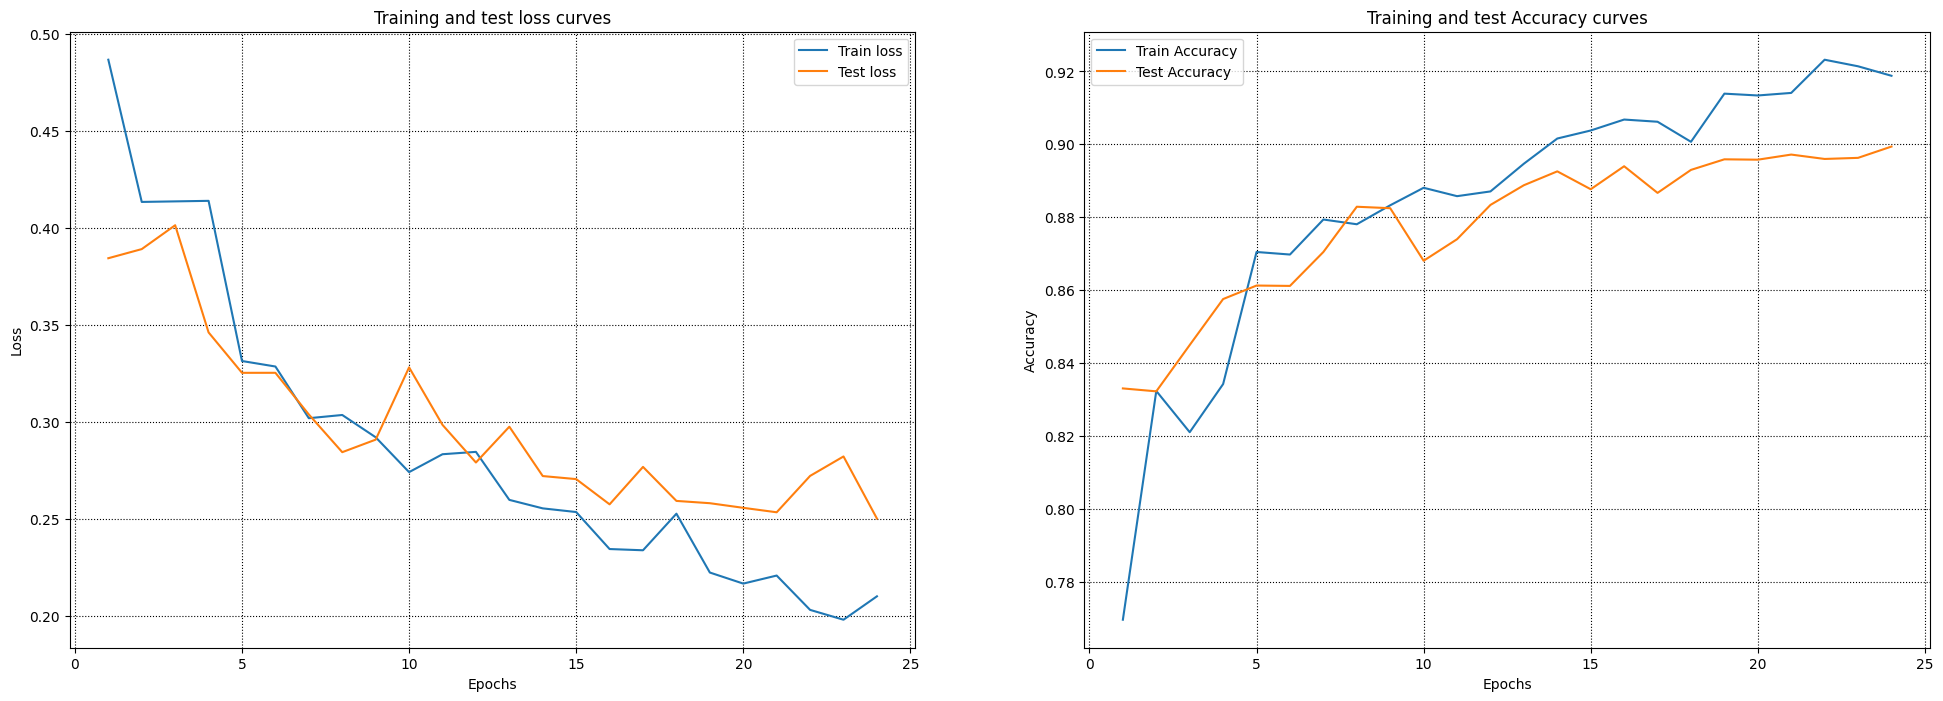

In [ ]:
plot_train_progress(train_losses_ext, val_losses_ext, train_accs_ext, val_accs_ext, 24)

In [ ]:
grnd_true, predictions = test_model(bidi_lstm_w2v_model, test_loader)

Test loss: 0.248
Test accuracy: 0.903


The accuracy of this model is slightly better.

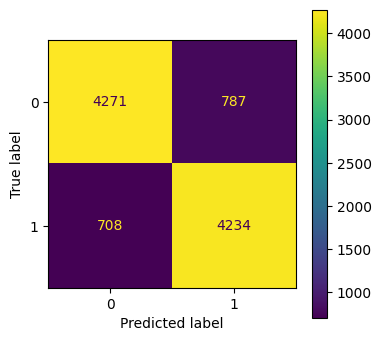

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      5058
         1.0       0.84      0.86      0.85      4942

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

F2-Score: 0.85


In [ ]:
report(grnd_true, predictions)

In [ ]:
model_save(bidi_lstm_w2v_model, 'BiDi_LSTM_W2V_sentiment_v1')

Saving model to: /content/drive/MyDrive/ds_data//BiDi_LSTM_W2V_sentiment_v1


# Conclusions

During the completion of this task, I become familiar with different types of RNN architectures - LSTM and BiDiLSTM, and learned how to define these models using Pytorch, train them, and how encode text data and load it into the models.<br>
I also got familiar with Word2Vec embeddings: how to train the W2V model, how to visualize the embedding space, and more importantly how to use obtained embeddings in the training of neural networks. <br>
Other things I have performed in this work are the early stopping algorithm and model saving. <br>
Unfortunately, I couldn't get a higher performance with NNs than I obtained with classical classification algorithms like SGDClassifier and SVM. But I am going to try other embeddings (Bert, Glove etc.) later. Probably they can give better results.